In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from textblob import TextBlob
from IPython.display import Image
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
import gensim

import warnings
warnings.filterwarnings('ignore')


In [2]:
meta_df_main=pd.read_csv(r"/content/Zomato Restaurant names and Metadata.csv")

In [3]:
meta_df = meta_df_main.copy()

In [4]:
meta_df.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [5]:
print(f' We have total {meta_df.shape[0]} rows and {meta_df.shape[1]} columns.')

 We have total 105 rows and 6 columns.


In [6]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB


In [7]:
meta_df.duplicated(keep='last').sum()

0

In [8]:
meta_df.reset_index(inplace=True)

In [9]:
meta_df['Name'].duplicated().sum()

0

In [10]:
meta_df.isnull().sum()

,0
index,0
Name,0
Links,0
Cost,0
Collections,54
Cuisines,0
Timings,1


In [11]:
meta_df[meta_df['Collections'].isnull()].head()

,index,Name,Links,Cost,Collections,Cuisines,Timings
7,7,Shah Ghouse Spl Shawarma,https://www.zomato.com/hyderabad/shah-ghouse-s...,300,NaN,Lebanese,12 Noon to 12 Midnight
15,15,KFC,https://www.zomato.com/hyderabad/kfc-gachibowli,500,NaN,"Burger, Fast Food",11 AM to 11 PM
16,16,NorFest - The Dhaba,https://www.zomato.com/hyderabad/norfest-the-d...,550,NaN,North Indian,12 Noon to 10:30 PM
17,17,Hotel Zara Hi-Fi,https://www.zomato.com/hyderabad/hotel-zara-ga...,400,NaN,"Chinese, North Indian",11:30 AM to 1 AM
23,23,Amul,https://www.zomato.com/hyderabad/amul-gachibowli,150,NaN,"Ice Cream, Desserts",10 AM to 5 AM


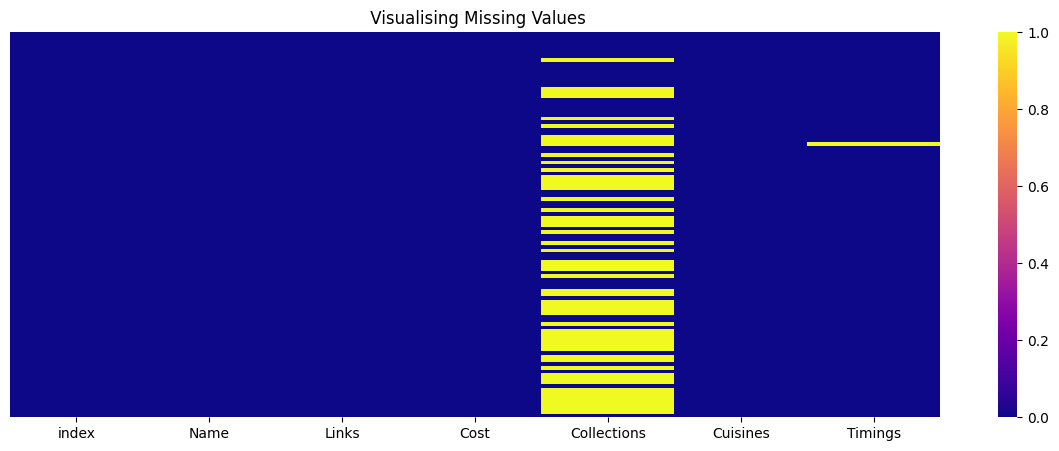

In [12]:
plt.figure(figsize=(15,5))
sns.heatmap(meta_df.isnull(),cmap='plasma',annot=False,yticklabels=False)
plt.title(" Visualising Missing Values");

In [13]:
meta_df.columns

Index(['index', 'Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings'], dtype='object')

In [14]:
meta_df['Cost'] =  meta_df['Cost'].str.replace(",","").astype('int64')

In [15]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        105 non-null    int64 
 1   Name         105 non-null    object
 2   Links        105 non-null    object
 3   Cost         105 non-null    int64 
 4   Collections  51 non-null     object
 5   Cuisines     105 non-null    object
 6   Timings      104 non-null    object
dtypes: int64(2), object(5)
memory usage: 5.9+ KB


In [16]:
top10_res_by_cost = meta_df[['Name','Cost']].groupby('Name',as_index=False).sum().sort_values(by='Cost',ascending=False).head(10)


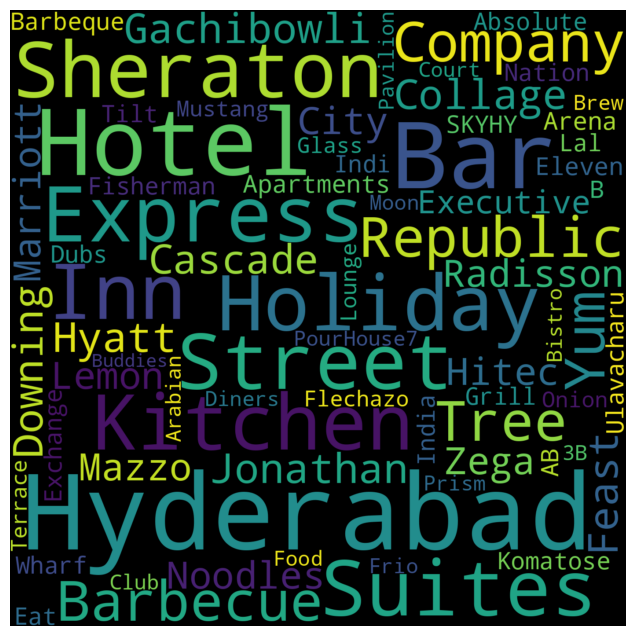

In [17]:
plt.figure(figsize=(15,8))
text = " ".join(name for name in meta_df.sort_values('Cost',ascending=False).Name[:30])


word_cloud = WordCloud(width = 1400, height = 1400,collocations = False, background_color = 'black').generate(text)


plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off");

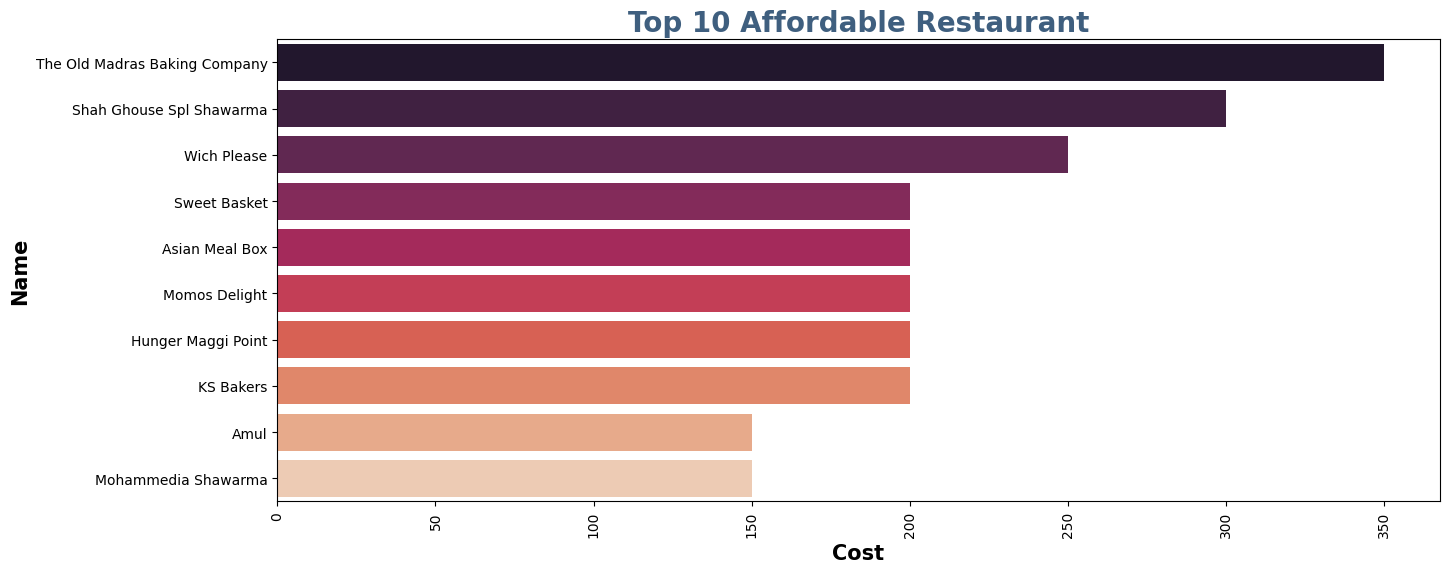

In [18]:
plt.figure(figsize=(15,6))


top_10_affor_rest=meta_df[['Name','Cost']].groupby('Name',as_index=False).sum().sort_values(by='Cost',ascending=False).tail(10)


x = top_10_affor_rest['Cost']
y = top_10_affor_rest['Name']


plt.title("Top 10 Affordable Restaurant",fontsize=20, weight='bold',color=sns.cubehelix_palette(8, start=.5, rot=-.75)[-3])
plt.ylabel("Name",weight='bold',fontsize=15)
plt.xlabel("Cost",weight='bold',fontsize=15)
plt.xticks(rotation=90)
sns.barplot(x=x, y=y,palette='rocket')
plt.show()

<Axes: ylabel='Collections'>

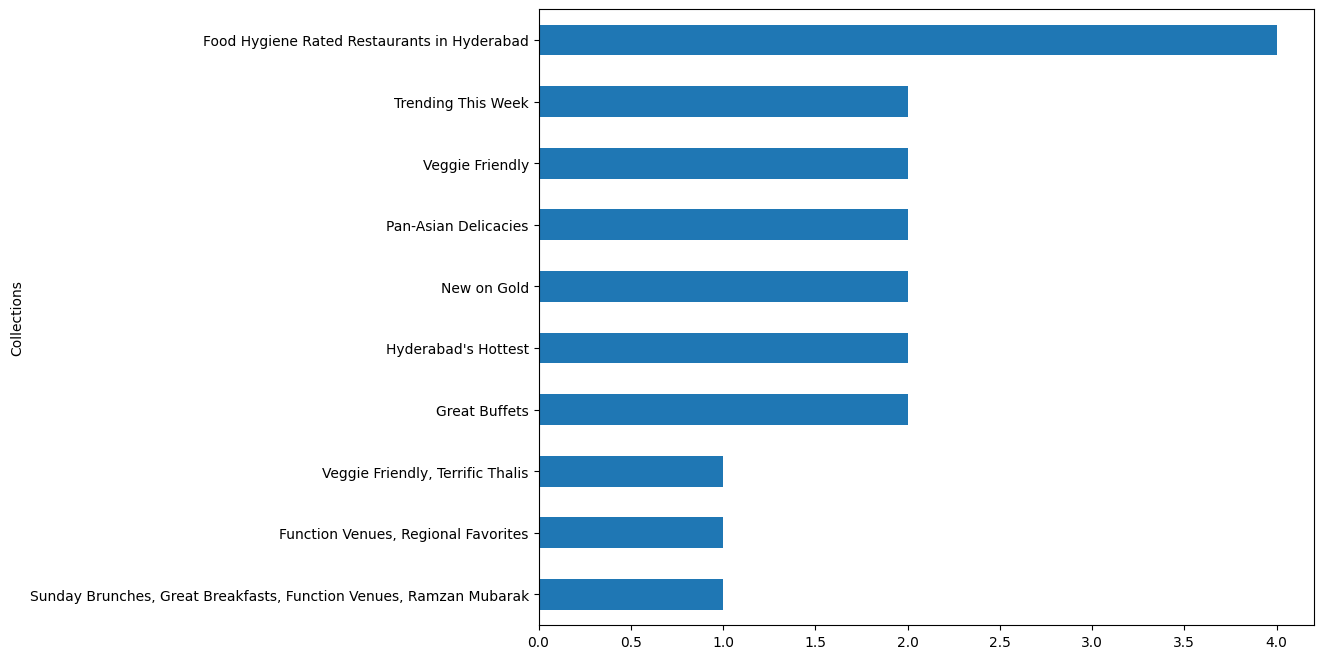

In [19]:
meta_df['Collections'].value_counts()[0:10].sort_values().plot(figsize=(10,8),kind='barh')


In [20]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
sw = stopwords.words('english')

In [22]:
def stopwords(text):
    '''a function for removing the stopword'''


    text = [word.lower() for word in str(text).split() if word.lower() not in sw]


    return " ".join(text)

In [23]:
meta_df['Cuisines'] = meta_df['Cuisines'].apply(lambda text: stopwords(text))
meta_df['Cuisines'].head()

,Cuisines
0,"chinese, continental, kebab, european, south i..."
1,"biryani, north indian, chinese"
2,"asian, mediterranean, north indian, desserts"
3,"biryani, north indian, chinese, seafood, bever..."
4,"asian, continental, north indian, chinese, med..."


In [24]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string


    translator = str.maketrans('', '', string.punctuation)


    return text.translate(translator)

In [25]:
meta_df['Cuisines'] = meta_df['Cuisines'].apply(lambda x: remove_punctuation(x))
meta_df['Cuisines'].head()

,Cuisines
0,chinese continental kebab european south india...
1,biryani north indian chinese
2,asian mediterranean north indian desserts
3,biryani north indian chinese seafood beverages
4,asian continental north indian chinese mediter...


In [26]:
import re

In [27]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

In [28]:
meta_df['Cuisines'] = meta_df['Cuisines'].apply(lambda x: cleaning_repeating_char(x))
meta_df['Cuisines'].head()

,Cuisines
0,chinese continental kebab european south india...
1,biryani north indian chinese
2,asian mediterranean north indian desserts
3,biryani north indian chinese seafood beverages
4,asian continental north indian chinese mediter...


In [29]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)


In [30]:
meta_df['Cuisines'] = meta_df['Cuisines'].apply(lambda x: cleaning_numbers(x))
meta_df['Cuisines'].head()

,Cuisines
0,chinese continental kebab european south india...
1,biryani north indian chinese
2,asian mediterranean north indian desserts
3,biryani north indian chinese seafood beverages
4,asian continental north indian chinese mediter...


In [31]:
from collections import Counter
text = ' '.join(meta_df['Cuisines'])


words = text.split()


two_words = {' '.join(words):n for words,n in Counter(zip(words, words[1:])).items() if not  words[0][-1]==(',')}


In [32]:
two_words_dfc = pd.DataFrame(two_words.items(), columns=['Cuisine Words', 'Frequency'])

two_words_dfc = two_words_dfc.sort_values(by = "Frequency", ascending = False)


two_words_20c = two_words_dfc[:20]
two_words_20c

,Cuisine Words,Frequency
6,north indian,61
9,indian chinese,27
42,fast food,15
4,south indian,9
5,indian north,9
33,chinese north,8
24,indian continental,6
65,italian north,6
8,biryani north,6
28,food north,6


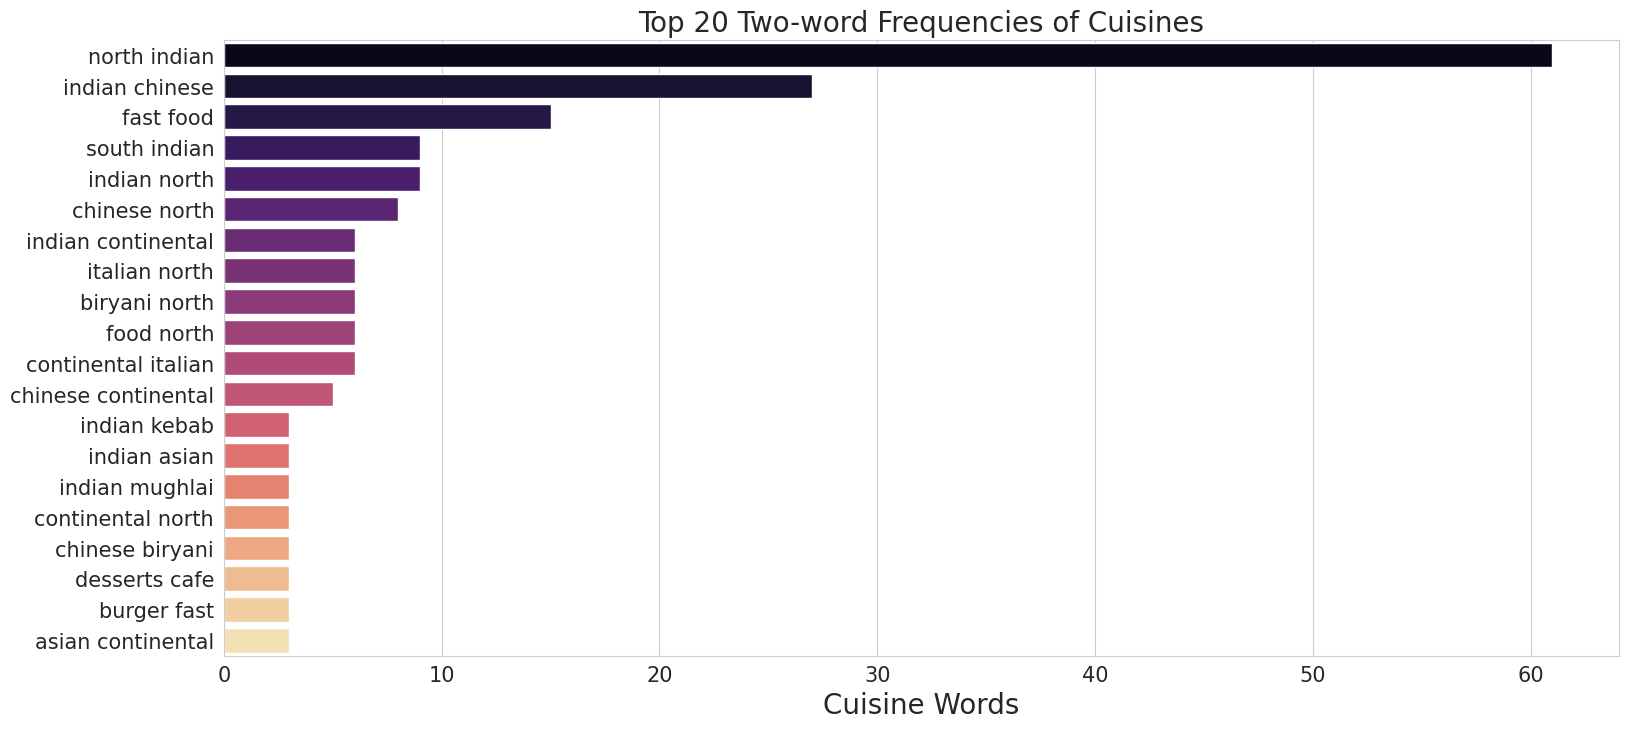

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize = (18, 8))
sns.barplot(y = "Cuisine Words", x = "Frequency", data = two_words_20c, palette = "magma")
plt.title("Top 20 Two-word Frequencies of Cuisines", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Cuisine Words", size = 20)
plt.ylabel(None)
plt.savefig("Top_20_Two-word_Frequencies_of_Cuisines.png")
plt.show()

In [35]:
review_df=pd.read_csv("/content/Zomato Restaurant reviews.csv")

In [36]:
review_df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [37]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [38]:
review_df.duplicated().sum()

36

In [39]:
review_df.isnull().sum()

,0
Restaurant,0
Reviewer,38
Review,45
Rating,38
Metadata,38
Time,38
Pictures,0


In [40]:
review_df['Rating'].value_counts(normalize=True)

,proportion
Rating,
5,0.384662
4,0.238205
1,0.174162
3,0.119755
2,0.068661
4.5,0.006926
3.5,0.004718
2.5,0.001907
1.5,0.000903


In [41]:
review_df.loc[review_df['Rating'] == 'Like'] = np.nan


review_df['Rating']= review_df['Rating'].astype('float64')

print(review_df['Rating'].mean())

3.601044071880333


In [42]:
review_df['Rating'].fillna(3.6, inplace=True)

In [43]:
review_df['Review'] = review_df['Review'].astype(str)


review_df['Review_length'] = review_df['Review'].apply(len)

In [44]:
review_df['Rating'].value_counts(normalize=True)

,proportion
Rating,
5.0,0.3832
4.0,0.2373
1.0,0.1735
3.0,0.1193
2.0,0.0684
4.5,0.0069
3.5,0.0047
3.6,0.0039
2.5,0.0019


In [45]:
import plotly.express as px
fig = px.scatter(review_df, x=review_df['Rating'], y=review_df['Review_length'])
fig.update_layout(title_text="Rating vs Review Length")
fig.update_xaxes(ticks="outside", tickwidth=1, tickcolor='crimson',tickangle=45, ticklen=10)
fig.show()

In [46]:
from textblob import TextBlob
review_df['Polarity'] = review_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

<Axes: ylabel='Frequency'>

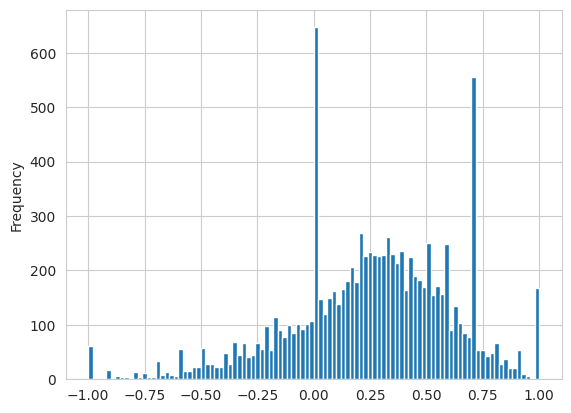

In [47]:
review_df['Polarity'].plot(kind='hist', bins=100)

In [49]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words('english')

print(stop_words)
rest_word=['order','restaurant','taste','ordered','good','food','table','place','one','also']
rest_word

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['order',
 'restaurant',
 'taste',
 'ordered',
 'good',
 'food',
 'table',
 'place',
 'one',
 'also']

In [50]:
reviewer_list = review_df.groupby('Reviewer').apply(lambda x: x['Reviewer'].count()).reset_index(name='Review_Count')


reviewer_list = reviewer_list.sort_values(by = 'Review_Count',ascending=False)


top_reviewers = reviewer_list[:15]

Text(0, 0.5, 'N of reviews')

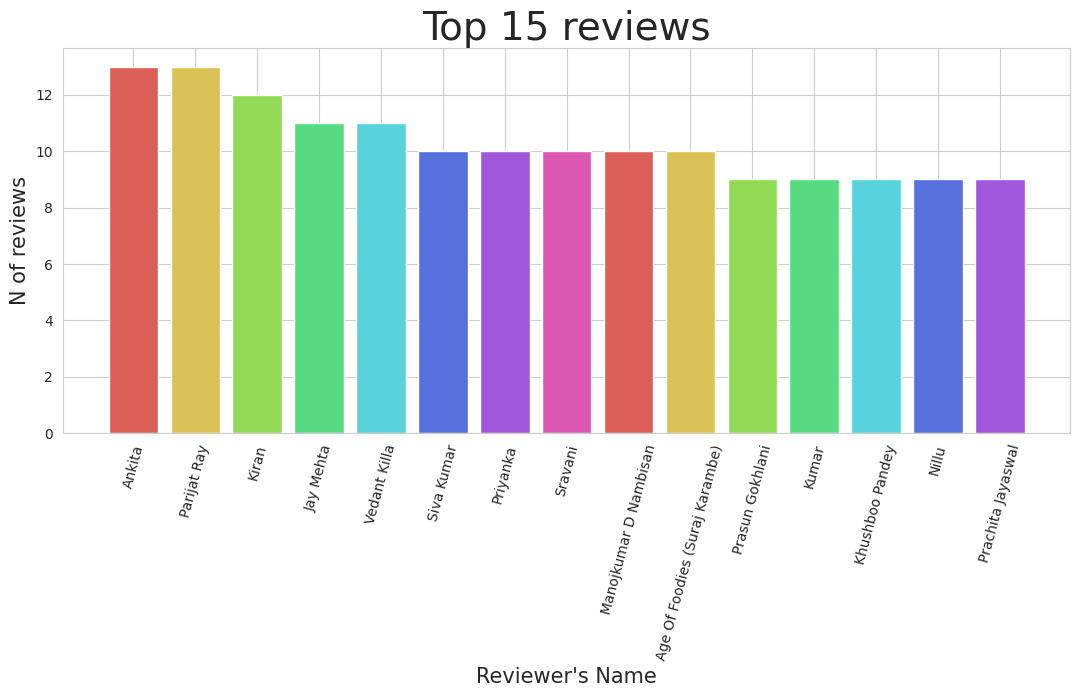

In [51]:
plt.figure(figsize=(13,5))
plt.bar(top_reviewers['Reviewer'], top_reviewers['Review_Count'], color = sns.color_palette("hls", 8))
plt.xticks(rotation=75)
plt.title('Top 15 reviews',size=28)
plt.xlabel("Reviewer's Name",size=15)
plt.ylabel('N of reviews',size=15)

In [52]:
review_ratings=review_df.groupby('Reviewer').apply(lambda x:np.average(x['Rating'])).reset_index(name='Average_Ratings')
review_ratings=pd.merge(top_reviewers,review_ratings,how='inner',left_on='Reviewer',right_on='Reviewer')
top_reviewers_ratings=review_ratings[:15]

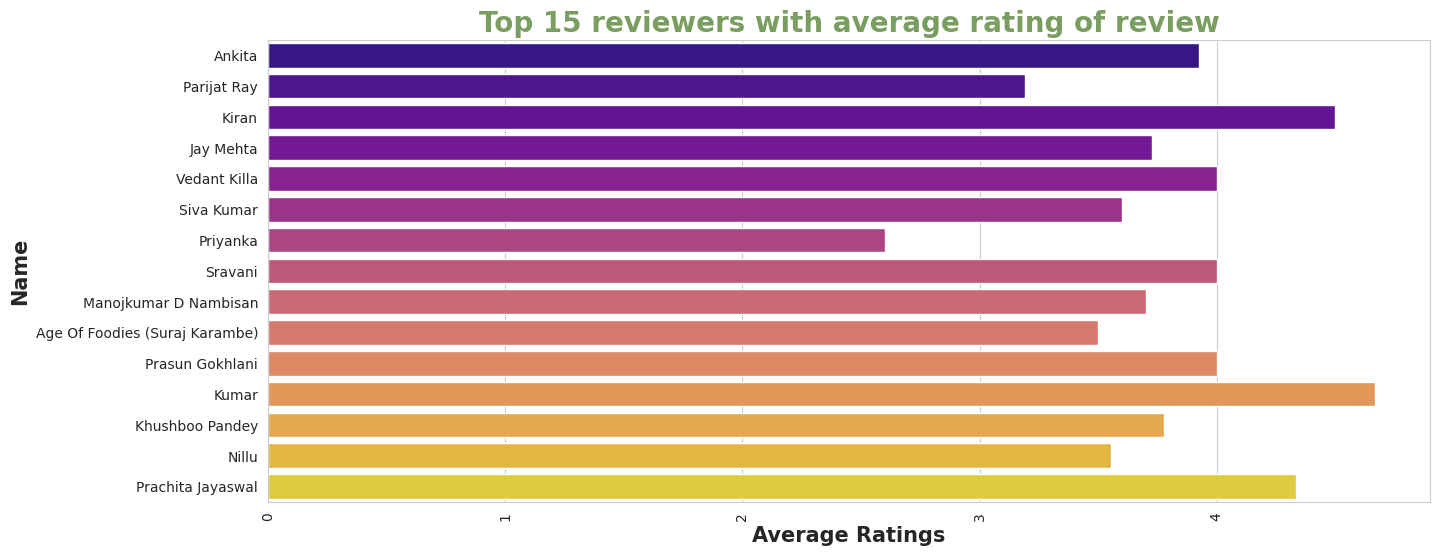

In [53]:
plt.figure(figsize=(15,6))
x = top_reviewers_ratings['Average_Ratings']
y = top_reviewers_ratings['Reviewer']
plt.title("Top 15 reviewers with average rating of review",fontsize=20, weight='bold',color=sns.cubehelix_palette(8, start=.5, rot=90)[-5])
plt.ylabel("Name",weight='bold',fontsize=15)
plt.xlabel("Average Ratings",weight='bold',fontsize=15)
plt.xticks(rotation=90)
sns.barplot(x=x, y=y,palette='plasma')
plt.show()

In [54]:
import re
review_df['Review']=review_df['Review'].map(lambda x: re.sub('[,\.!?]','', x))
review_df['Review']=review_df['Review'].map(lambda x: x.lower())
review_df['Review']=review_df['Review'].map(lambda x: x.split())
review_df['Review']=review_df['Review'].apply(lambda x: [item for item in x if item not in stop_words])
review_df['Review']=review_df['Review'].apply(lambda x: [item for item in x if item not in rest_word])

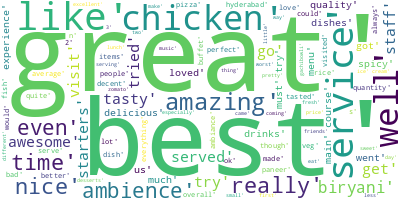

In [55]:
from wordcloud import WordCloud
review_df['Review']=review_df['Review'].astype(str)

ps = PorterStemmer()
review_df['Review']=review_df['Review'].map(lambda x: ps.stem(x))
long_string = ','.join(list(review_df['Review'].values))
long_string
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [56]:
review_df['Rating']= pd.to_numeric(review_df['Rating'],errors='coerce')   # The to_numeric() function in pandas is used to convert a pandas object to a numeric type.
pos_rev = review_df[review_df.Rating>= 3]
neg_rev = review_df[review_df.Rating< 3]

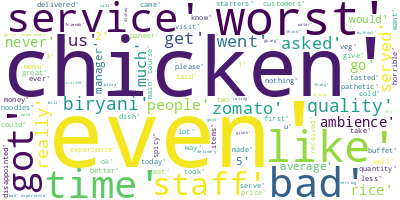

In [57]:
long_string = ','.join(list(neg_rev['Review'].values))
long_string
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [58]:
from gensim.models import word2vec
pos_rev = review_df[review_df.Rating>= 3]
neg_rev = review_df[review_df.Rating< 3]

In [60]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['Review']:
        for sentence in data[col].items():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)

    return corpus


corpus = build_corpus(neg_rev)
corpus[0:2]

[["['corn',",
  "'cheese',",
  "'balls',",
  "'manchow',",
  "'soup',",
  "'paneer',",
  "'shashlik',",
  "'sizzler',",
  "'sizzler',",
  "'stale',",
  "'paneer',",
  "'smelling',",
  "'waiter',",
  "'impolite',",
  "'even',",
  "'accept',",
  "'mistake',",
  "'never',",
  "'going']"],
 ["['went',",
  "'team',",
  "'lunch',",
  "'worst',",
  "'tasteless',",
  "'service',",
  "'slow',",
  "'ac',",
  "'working',",
  "'we’ve',",
  "'requested',",
  "'multiple',",
  "'times',",
  "'use',",
  "'please',",
  "'don’t',",
  "'waste',",
  "'money',",
  "'strictly',",
  "'recommend',",
  "'prefer',",
  "'beyond',",
  "'flavours']"]]

In [62]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['Review']:
        for sentence in data[col].items():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)

    return corpus


corpus = build_corpus(pos_rev)
corpus[0:2]

[["['ambience',",
  "'quite',",
  "'saturday',",
  "'lunch',",
  "'cost',",
  "'effective',",
  "'sate',",
  "'brunch',",
  "'chill',",
  "'friends',",
  "'parents',",
  "'waiter',",
  "'soumen',",
  "'das',",
  "'really',",
  "'courteous',",
  "'helpful']"],
 ["['ambience',",
  "'pleasant',",
  "'evening',",
  "'service',",
  "'prompt',",
  "'experience',",
  "'soumen',",
  "'das',",
  "'-',",
  "'kudos',",
  "'service']"]]

In [63]:
review_df['Review']

,Review
0,"['ambience', 'quite', 'saturday', 'lunch', 'co..."
1,"['ambience', 'pleasant', 'evening', 'service',..."
2,"['must', 'try', 'great', 'great', 'ambience', ..."
3,"['soumen', 'das', 'arun', 'great', 'guy', 'beh..."
4,"['goodwe', 'kodi', 'drumsticks', 'basket', 'mu..."
...,...
9995,"['madhumathi', 'mahajan', 'well', 'start', 'ni..."
9996,"['never', 'disappointed', 'us', 'courteous', '..."
9997,"['bad', 'rating', 'mainly', '""chicken', 'bone'..."
9998,"['personally', 'love', 'prefer', 'chinese', 'c..."


In [64]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess


In [65]:
tokenized_docs = [simple_preprocess(doc) for doc in review_df['Review']]


dictionary = corpora.Dictionary(tokenized_docs)


bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]


num_topics = 10
lda_model = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=10)


for topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print('Topic {}: {}'.format(topic[0], ', '.join([term[0] for term in topic[1]])))

Topic 0: chicken, veg, starters, main, course, fish, ambience, soup, like, buffet
Topic 1: paneer, like, paratha, butter, dal, tasty, chicken, breakfast, well, combo
Topic 2: delivery, time, floor, night, dance, late, burgers, fast, best, better
Topic 3: chicken, quantity, biryani, rice, less, spicy, cooked, pieces, indian, fried
Topic 4: bad, even, worst, service, experience, never, time, zomato, ever, got
Topic 5: biryani, service, chicken, momos, ambience, time, quality, like, times, try
Topic 6: pizza, cheese, burger, pasta, chicken, try, best, seating, must, cream
Topic 7: cake, chocolate, try, coffee, must, mandi, love, best, donuts, cakes
Topic 8: service, great, ambience, nice, staff, visit, really, amazing, awesome, best
Topic 9: hyderabadi, quite, brunch, carte, la, daawat, well, sunday, sizzler, manchow


In [74]:
import gensim
import pyLDAvis.gensim
import pyLDAvis
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

In [75]:
lda_visualization = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, mds='tsne')
pyLDAvis.display(lda_visualization)


In [76]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.express as px


In [77]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


In [78]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [79]:
review_df['Subjectivity'] = review_df['Review'].apply(subjectivity)
review_df['Polarity'] = review_df['Review'].apply(polarity)

In [80]:
review_df['Polarity']

,Polarity
0,0.600000
1,0.733333
2,0.540000
3,0.800000
4,0.350000
...,...
9995,0.277841
9996,0.174621
9997,0.082074
9998,0.560000


In [81]:
review_df['Subjectivity']

,Subjectivity
0,0.900000
1,0.966667
2,0.740000
3,0.750000
4,0.450000
...,...
9995,0.646591
9996,0.710606
9997,0.501252
9998,0.620000


In [82]:
def getAnalysis(score):
    if score <0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [83]:
review_df['Analysis'] = review_df['Polarity'].apply(getAnalysis)

In [84]:
fig = px.scatter(review_df,
                 x='Polarity',
                 y='Subjectivity',
                 color = 'Analysis',
                 size='Subjectivity')

In [85]:
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1,
                               xref= 'x', x0= 0, x1= 0)])
fig.show()


In [86]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning);

In [87]:
meta_df_main['Cuisines'] = meta_df_main['Cuisines'].apply(lambda x : x.lower());

In [90]:
cuisine_df = meta_df_main.loc[:,['Name','Cost','Cuisines']]

In [91]:
cuisine_df.head()

,Name,Cost,Cuisines
0,Beyond Flavours,800,"chinese, continental, kebab, european, south i..."
1,Paradise,800,"biryani, north indian, chinese"
2,Flechazo,"1,300","asian, mediterranean, north indian, desserts"
3,Shah Ghouse Hotel & Restaurant,800,"biryani, north indian, chinese, seafood, bever..."
4,Over The Moon Brew Company,"1,200","asian, continental, north indian, chinese, med..."


In [92]:
cuisine_df['Cuisines'] = cuisine_df['Cuisines'].str.replace(' ','')


cuisine_df['Cuisines'] = cuisine_df['Cuisines'].str.split(',')

In [93]:
cuisine_df.head()


,Name,Cost,Cuisines
0,Beyond Flavours,800,"[chinese, continental, kebab, european, southi..."
1,Paradise,800,"[biryani, northindian, chinese]"
2,Flechazo,"1,300","[asian, mediterranean, northindian, desserts]"
3,Shah Ghouse Hotel & Restaurant,800,"[biryani, northindian, chinese, seafood, bever..."
4,Over The Moon Brew Company,"1,200","[asian, continental, northindian, chinese, med..."


In [94]:

from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer(sparse_output=True)

In [95]:
cuisine_df = cuisine_df.join(pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(cuisine_df.pop('Cuisines')),
                                                               index=cuisine_df.index, columns=mlb.classes_))


In [96]:
cuisine_df.head()


,Name,Cost,american,andhra,arabian,asian,bakery,bbq,beverages,biryani,...,northindian,pizza,salad,seafood,southindian,spanish,streetfood,sushi,thai,wraps
0,Beyond Flavours,800,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,Paradise,800,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,Flechazo,"1,300",0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Shah Ghouse Hotel & Restaurant,800,0,0,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,0,0
4,Over The Moon Brew Company,"1,200",0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [97]:
review_df['Rating'].unique()

array([5. , 4. , 1. , 3. , 2. , 3.5, 4.5, 2.5, 1.5, 3.6])

In [98]:
review_df.dropna(subset=['Rating'],inplace=True)

In [99]:
review_df['Rating']= review_df['Rating'].astype('float')

In [100]:
review_df.dropna(subset =['Review'], inplace=True)

In [101]:
ratings_df = review_df.groupby('Restaurant')['Rating'].mean().reset_index()

In [102]:
ratings_df .sort_values(by='Rating',ascending = False).head(15)

,Restaurant,Rating
3,AB's - Absolute Barbecues,4.880
11,B-Dubs,4.810
2,"3B's - Buddies, Bar & Barbecue",4.760
67,Paradise,4.700
35,Flechazo,4.660
87,The Indi Grill,4.600
97,Zega - Sheraton Hyderabad Hotel,4.450
64,Over The Moon Brew Company,4.340
16,Beyond Flavours,4.280
19,Cascade - Radisson Hyderabad Hitec City,4.260


In [103]:
df_cluster = cuisine_df.merge(ratings_df, left_on='Name',right_on='Restaurant')

In [104]:
df_cluster.head()

,Name,Cost,american,andhra,arabian,asian,bakery,bbq,beverages,biryani,...,salad,seafood,southindian,spanish,streetfood,sushi,thai,wraps,Restaurant,Rating
0,Beyond Flavours,800,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,Beyond Flavours,4.28
1,Paradise,800,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,Paradise,4.70
2,Flechazo,"1,300",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Flechazo,4.66
3,Shah Ghouse Hotel & Restaurant,800,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,Shah Ghouse Hotel & Restaurant,3.21
4,Over The Moon Brew Company,"1,200",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Over The Moon Brew Company,4.34


In [105]:
df_cluster = df_cluster[['Name', 'Cost','Rating', 'american', 'andhra', 'arabian', 'asian', 'bbq',
       'bakery', 'beverages', 'biryani', 'burger', 'cafe', 'chinese',
       'continental', 'desserts', 'european', 'fastfood', 'fingerfood', 'goan',
       'healthyfood', 'hyderabadi', 'icecream', 'indonesian', 'italian',
       'japanese', 'juices', 'kebab', 'lebanese', 'malaysian', 'mediterranean',
       'mexican', 'mithai', 'modernindian', 'momos', 'mughlai', 'northeastern',
       'northindian', 'pizza', 'salad', 'seafood', 'southindian', 'spanish',
       'streetfood', 'sushi', 'thai', 'wraps']]

In [106]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype           
---  ------         --------------  -----           
 0   Name           100 non-null    object          
 1   Cost           100 non-null    object          
 2   Rating         100 non-null    float64         
 3   american       1 non-null      Sparse[int64, 0]
 4   andhra         1 non-null      Sparse[int64, 0]
 5   arabian        1 non-null      Sparse[int64, 0]
 6   asian          1 non-null      Sparse[int64, 0]
 7   bbq            1 non-null      Sparse[int64, 0]
 8   bakery         1 non-null      Sparse[int64, 0]
 9   beverages      1 non-null      Sparse[int64, 0]
 10  biryani        1 non-null      Sparse[int64, 0]
 11  burger         1 non-null      Sparse[int64, 0]
 12  cafe           1 non-null      Sparse[int64, 0]
 13  chinese        1 non-null      Sparse[int64, 0]
 14  continental    1 non-null      Sparse[int64

In [107]:
df_cluster

,Name,Cost,Rating,american,andhra,arabian,asian,bbq,bakery,beverages,...,northindian,pizza,salad,seafood,southindian,spanish,streetfood,sushi,thai,wraps
0,Beyond Flavours,800,4.280,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,Paradise,800,4.700,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Flechazo,"1,300",4.660,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,Shah Ghouse Hotel & Restaurant,800,3.210,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
4,Over The Moon Brew Company,"1,200",4.340,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Desi Bytes,400,2.900,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
96,Hyderabadi Daawat,600,3.830,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,Zega - Sheraton Hyderabad Hotel,"1,750",4.450,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
98,Triptify,400,3.550,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [108]:
df_cluster['Cost']= df_cluster['Cost'].str.replace(',','')

In [109]:
df_cluster['Cost']= df_cluster['Cost'].astype('float')

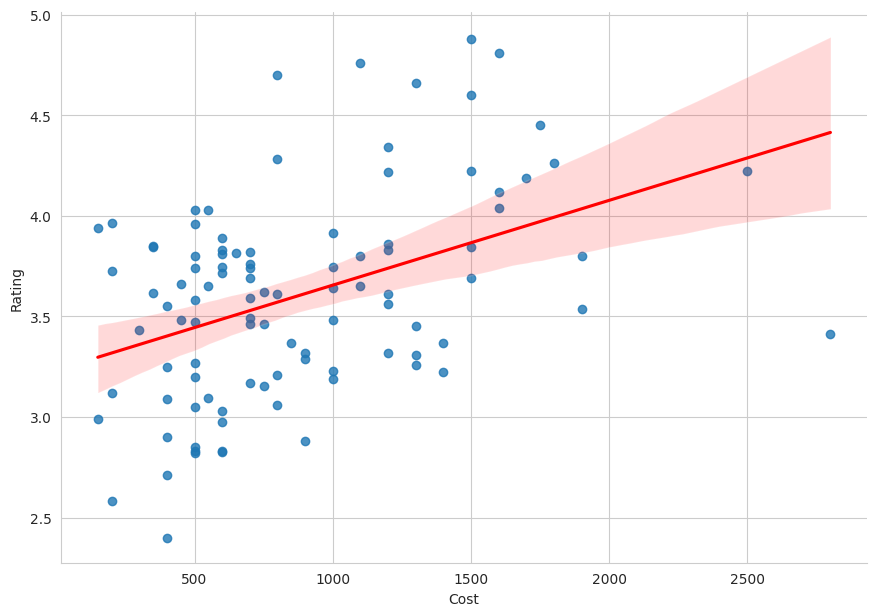

In [110]:
sns.lmplot(y='Rating',x='Cost',data=df_cluster,line_kws={'color' :'red'},height=6.27, aspect=11.7/8.27)


In [112]:

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

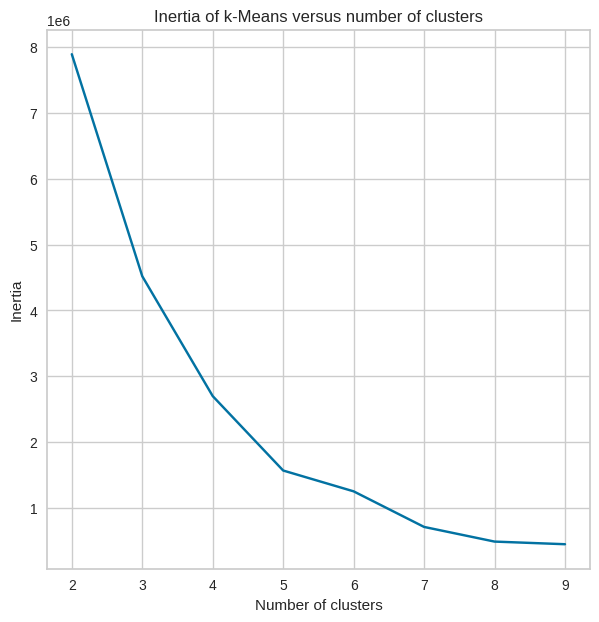

In [114]:
scores = [KMeans(n_clusters=i+2, random_state=11).fit(df_cluster.drop('Name',axis=1)).inertia_
          for i in range(8)]

plt.figure(figsize=(7,7))
sns.lineplot(x=np.arange(2, 10), y=scores)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia of k-Means versus number of clusters')
plt.show()

In [115]:
model = KMeans(random_state=11, n_clusters=5)
model.fit(df_cluster.drop('Name',axis=1))

KMeans(n_clusters=5, random_state=11)

In [116]:
cluster_lbl = model.predict(df_cluster.drop('Name',axis=1))

In [118]:
df_cluster['labels'] = cluster_lbl

In [119]:
cluster_0 = df_cluster[df_cluster['labels'] == 0].reset_index()
cluster_1 = df_cluster[df_cluster['labels'] == 1].reset_index()
cluster_2 = df_cluster[df_cluster['labels'] == 2].reset_index()
cluster_3 = df_cluster[df_cluster['labels'] == 3].reset_index()
cluster_4 = df_cluster[df_cluster['labels'] == 4].reset_index()


In [121]:
list_of_cluster=[cluster_0,cluster_1,cluster_2,cluster_3,cluster_4]

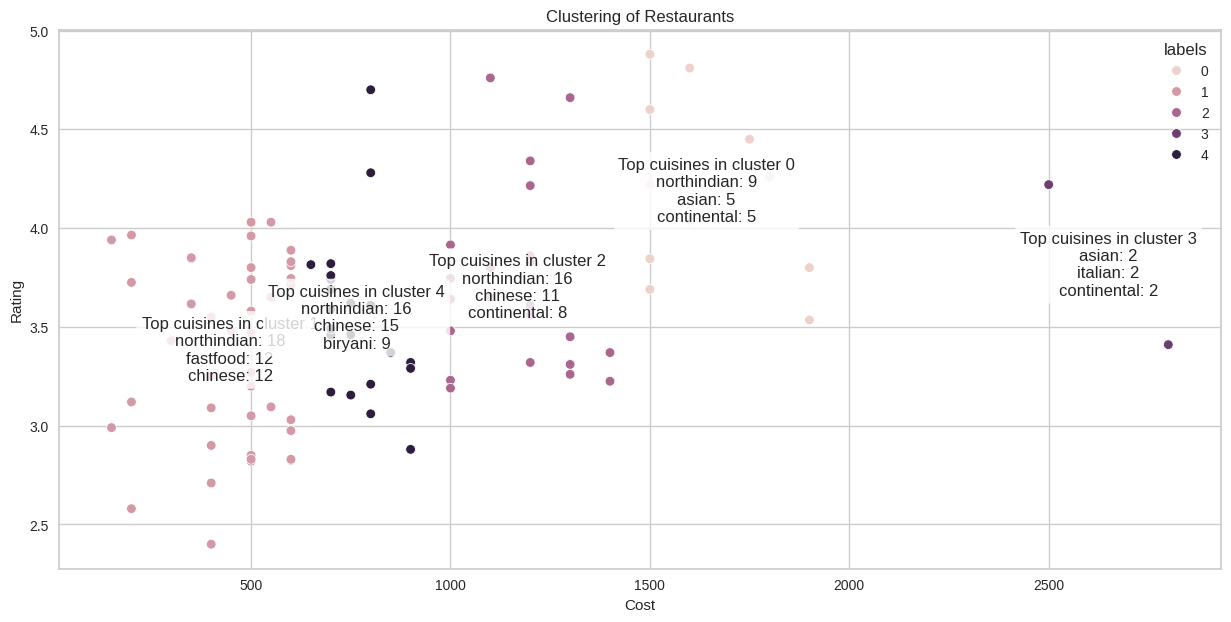

In [122]:
plt.figure(figsize=(15,7))
sns.scatterplot(x='Cost', y='Rating', hue='labels', data=df_cluster)


for i, df in enumerate(list_of_cluster):
    top_cuisines = df.drop(['index', 'Name', 'Cost', 'Rating', 'labels'], axis=1).sum().sort_values(ascending=False)[:3]
    top_cuisines_str = '\n'.join([f'{cuisine}: {count}' for cuisine, count in top_cuisines.items()])
    plt.annotate(f'Top cuisines in cluster {i}\n{top_cuisines_str}',
                 xy=(df['Cost'].mean(), df['Rating'].mean()),
                 ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Cost')
plt.ylabel('Rating')
plt.title('Clustering of Restaurants')
plt.show()

In [123]:
for i,df in enumerate(list_of_cluster):
  print(f'Top cuisines in cluster {i}\n', df.drop(['index','Name','Cost','Rating','labels'],axis=1).sum().sort_values(ascending=False)[:3],'\n')


Top cuisines in cluster 0
 northindian    9
asian          5
continental    5
dtype: Sparse[int64, 0] 

Top cuisines in cluster 1
 northindian    18
fastfood       12
chinese        12
dtype: Sparse[int64, 0] 

Top cuisines in cluster 2
 northindian    16
chinese        11
continental     8
dtype: Sparse[int64, 0] 

Top cuisines in cluster 3
 asian          2
italian        2
continental    2
dtype: Sparse[int64, 0] 

Top cuisines in cluster 4
 northindian    16
chinese        15
biryani         9
dtype: Sparse[int64, 0] 

